<h3>Current working model</h3>

In [1]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
# ==== Load Data ====
data = np.load("Train_Data/option_train_labeled.npz", allow_pickle=True)
# X = data['X'].reshape(data['X'].shape[0], -1)
labels = data['labels']
le = LabelEncoder()
y = le.fit_transform(labels)


In [2]:
labels

array(['NO', 'NO', 'NO', ..., 'NO', 'NO', 'NO'], dtype='<U10')

In [3]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [2]:
import xgboost as xgb
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ==== Load Data ====
data = np.load("Train_Data/option_train_labeled.npz", allow_pickle=True)
X = data['X'].reshape(data['X'].shape[0], -1)
labels = data['labels']
le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert to DMatrix (required by xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

# ==== Model Params ====
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 16,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'device': 'cuda'
}

# ==== Get Latest Checkpoint ====

def get_latest_checkpoint(prefix="xgb_checkpoint_", ext="ubj"):
    files = glob.glob(f"{prefix}*.{ext}")
    if not files:
        print("❌ No checkpoint files found.")
        return None
    latest = max(files, key=os.path.getctime)
    print(f"✅ Found latest checkpoint: {latest}")
    return latest

checkpoint_path = get_latest_checkpoint()

# ==== Resume or Train ====
if checkpoint_path:
    print(f"🔁 Resuming training from: {checkpoint_path}")
    booster = xgb.Booster()
    booster.load_model(checkpoint_path)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,  # This is total rounds, not additional
        evals=[(dvalid, 'validation')],
        xgb_model=booster,
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )
else:
    print("🚀 Starting new training...")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dvalid, 'validation')],
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )


✅ Found latest checkpoint: xgb_checkpoint_150.ubj
🔁 Resuming training from: xgb_checkpoint_150.ubj
[0]	validation-mlogloss:0.22451
[1]	validation-mlogloss:0.22420
[2]	validation-mlogloss:0.22392
[3]	validation-mlogloss:0.22354
[4]	validation-mlogloss:0.22338
[5]	validation-mlogloss:0.22314
[6]	validation-mlogloss:0.22274
[7]	validation-mlogloss:0.22236
[8]	validation-mlogloss:0.22231
[9]	validation-mlogloss:0.22149
[10]	validation-mlogloss:0.22139
[11]	validation-mlogloss:0.22093
[12]	validation-mlogloss:0.22058
[13]	validation-mlogloss:0.22053
[14]	validation-mlogloss:0.22046
[15]	validation-mlogloss:0.22012
[16]	validation-mlogloss:0.22008
[17]	validation-mlogloss:0.22006
[18]	validation-mlogloss:0.21995
[19]	validation-mlogloss:0.21970
[20]	validation-mlogloss:0.21966
[21]	validation-mlogloss:0.21940
[22]	validation-mlogloss:0.21935
[23]	validation-mlogloss:0.21930
[24]	validation-mlogloss:0.21926
[25]	validation-mlogloss:0.21924
[26]	validation-mlogloss:0.21916
[27]	validation-mlog


✅ Accuracy: 0.9272
              precision    recall  f1-score   support

         BUY       0.95      0.67      0.78     89312
          NO       0.92      0.99      0.96    383074
  STRONG BUY       0.99      0.43      0.60      4217

    accuracy                           0.93    476603
   macro avg       0.95      0.70      0.78    476603
weighted avg       0.93      0.93      0.92    476603



C:\Users\sibaj\AppData\Local\Temp\ipykernel_11596\672506785.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\TradeBot\tr-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


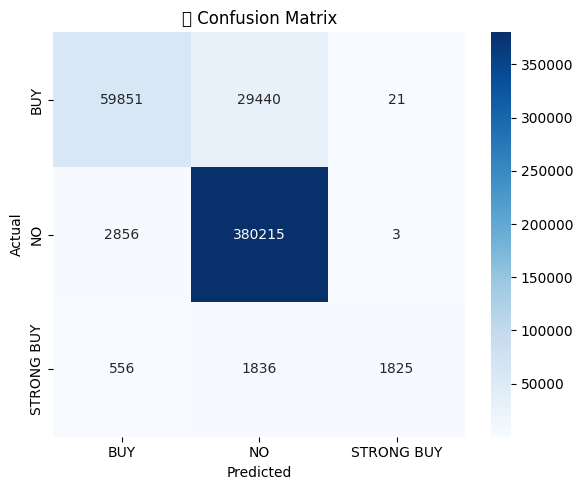

In [4]:
# ======== Predict and Evaluate ========
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_  # decoded class labels

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [7]:
model.save_model("final_model.ubj")
print("💾 Model saved as final_model.ubj")


💾 Model saved as final_model.ubj



✅ Accuracy: 0.9651
              precision    recall  f1-score   support

         BUY       0.99      0.83      0.90    357933
          NO       0.96      1.00      0.98   1531783
  STRONG BUY       1.00      0.73      0.84     16695

    accuracy                           0.97   1906411
   macro avg       0.98      0.85      0.91   1906411
weighted avg       0.97      0.97      0.96   1906411



C:\Users\sibaj\AppData\Local\Temp\ipykernel_11596\341024964.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\TradeBot\tr-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


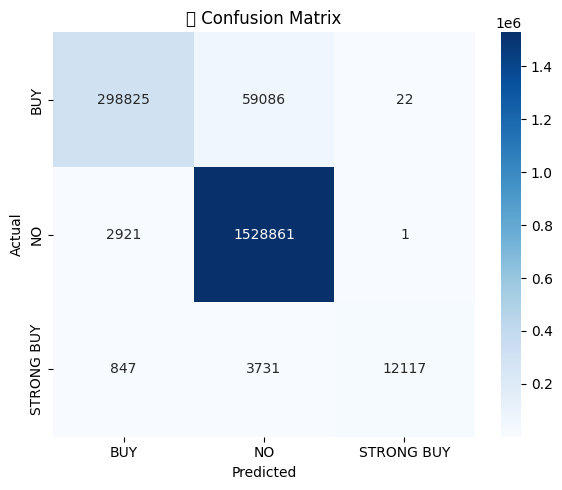

In [6]:
# ======== Predict and Evaluate ========
dtrain = xgb.DMatrix(X_train)
y_pred = model.predict(dtrain)

from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_train, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print(classification_report(y_train, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)
labels = le.classes_  # decoded class labels

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


<h3>3 Min labelled Data</h3>


[10]	validation-mlogloss:0.05305

In [3]:
import xgboost as xgb
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ==== Load Data ====
data = np.load("Train_Data/option_train_labeled_3m.npz", allow_pickle=True)
X = data['X'].reshape(data['X'].shape[0], -1)
labels = data['labels']
le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix (required by xgb.train)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

# BUY = 1, NO = 0
n_no = sum(y_train == 0)
n_buy = sum(y_train == 1)

scale_pos_weight = n_no / n_buy

# ==== Model Params ====
params = {
    # 'objective': 'binary:logistic',
    'objective': 'multi:softmax',
    'num_class': 2,
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 12,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'device': 'cuda'
}

# ==== Get Latest Checkpoint ====

def get_latest_checkpoint(prefix="xgb_checkpoint_", ext="ubj"):
    files = glob.glob(f"{prefix}*.{ext}")
    if not files:
        print("❌ No checkpoint files found.")
        return None
    latest = max(files, key=os.path.getctime)
    print(f"✅ Found latest checkpoint: {latest}")
    return latest

checkpoint_path = get_latest_checkpoint()

# ==== Resume or Train ====
if checkpoint_path:
    print(f"🔁 Resuming training from: {checkpoint_path}")
    booster = xgb.Booster()
    booster.load_model(checkpoint_path)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=5000,  # This is total rounds, not additional
        evals=[(dvalid, 'validation')],
        xgb_model=booster,
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )
else:
    print("🚀 Starting new training...")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, 'validation')],
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )


✅ Found latest checkpoint: xgb_checkpoint_501.ubj
🔁 Resuming training from: xgb_checkpoint_501.ubj


e:\TradeBot\tr-gpu\lib\site-packages\xgboost\callback.py:636: UserWarning: [17:59:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  self._start = model.num_boosted_rounds()


[0]	validation-mlogloss:0.21065
[1]	validation-mlogloss:0.21067
[2]	validation-mlogloss:0.21064
[3]	validation-mlogloss:0.21058
[4]	validation-mlogloss:0.21058
[5]	validation-mlogloss:0.21059
[6]	validation-mlogloss:0.21049
[7]	validation-mlogloss:0.21037
[8]	validation-mlogloss:0.21022
[9]	validation-mlogloss:0.21021
[10]	validation-mlogloss:0.21003
[11]	validation-mlogloss:0.20991
[12]	validation-mlogloss:0.20992
[13]	validation-mlogloss:0.20990
[14]	validation-mlogloss:0.20991
[15]	validation-mlogloss:0.20991
[16]	validation-mlogloss:0.20990
[17]	validation-mlogloss:0.20982
[18]	validation-mlogloss:0.20973
[19]	validation-mlogloss:0.20974
[20]	validation-mlogloss:0.20975
[21]	validation-mlogloss:0.20976
[22]	validation-mlogloss:0.20969
[23]	validation-mlogloss:0.20964
[24]	validation-mlogloss:0.20965
[25]	validation-mlogloss:0.20965
[26]	validation-mlogloss:0.20967
[27]	validation-mlogloss:0.20968
[28]	validation-mlogloss:0.20968
[29]	validation-mlogloss:0.20971
[30]	validation-mlog


✅ Accuracy: 0.9259
              precision    recall  f1-score   support

         BUY       0.87      0.06      0.11     37264
          NO       0.93      1.00      0.96    439339

    accuracy                           0.93    476603
   macro avg       0.90      0.53      0.54    476603
weighted avg       0.92      0.93      0.90    476603



C:\Users\sibaj\AppData\Local\Temp\ipykernel_28184\2363085616.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\TradeBot\tr-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


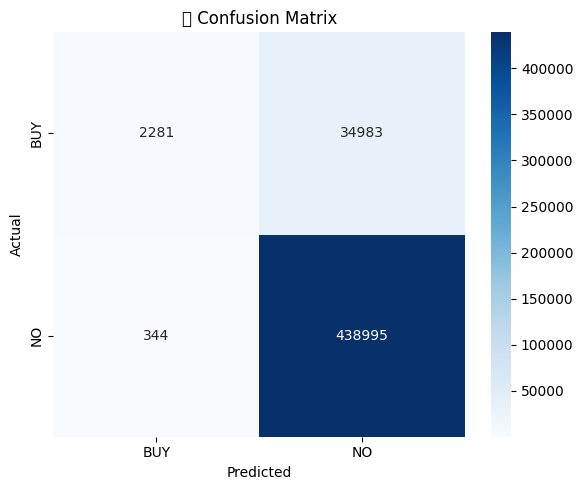

In [4]:
# ======== Predict and Evaluate ========
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

from sklearn.metrics import accuracy_score, classification_report

# If using 'binary:logistic', apply threshold:
y_pred = (y_pred > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = le.classes_  # decoded class labels

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
# ======== Predict and Evaluate ========
dtrain = xgb.DMatrix(X_train)
y_pred = model.predict(dtrain)

from sklearn.metrics import accuracy_score, classification_report
# y_pred = (y_pred > 0.5).astype(int)
acc = accuracy_score(y_train, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print(classification_report(y_train, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)
labels = le.classes_  # decoded class labels

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [22]:
model.save_model("Saved_XGB_models/final_model_3m.ubj")
print("💾 Model saved as final_model_3m.ubj"    )

💾 Model saved as final_model_3m.ubj


Test model against Data


✅ Accuracy: 0.9170
              precision    recall  f1-score   support

         BUY       0.21      0.01      0.02     15354
          NO       0.92      1.00      0.96    173506

    accuracy                           0.92    188860
   macro avg       0.57      0.50      0.49    188860
weighted avg       0.86      0.92      0.88    188860



C:\Users\sibaj\AppData\Local\Temp\ipykernel_28184\3347889356.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
e:\TradeBot\tr-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


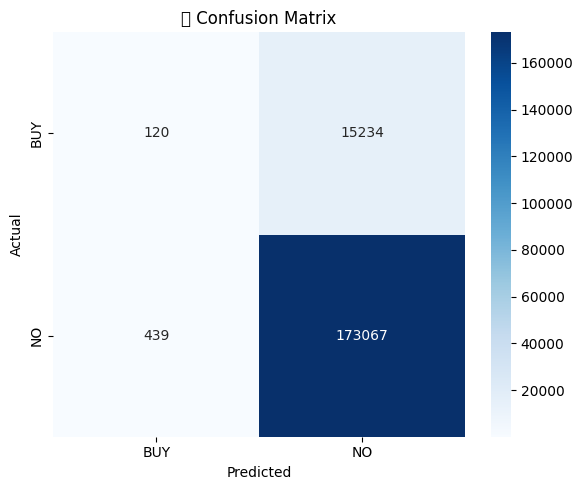

In [5]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder

# model = xgb.Booster()
# model.load_model("Saved_XGB_models/final_model_3m.ubj")
# model.load_model("xgb_checkpoint_7804.ubj")
# ======== Predict and Evaluate ========
data = np.load("Train_Data/option_train__labeled_3m_06_06_2025.npz", allow_pickle=True)
X = data['X'].reshape(data['X'].shape[0], -1)
labels = data['labels']
le = LabelEncoder()
y = le.fit_transform(labels)
dtrain = xgb.DMatrix(X)
y_pred = model.predict(dtrain)

from sklearn.metrics import accuracy_score, classification_report
y_pred = (y_pred > 0.5).astype(int)
acc = accuracy_score(y, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print(classification_report(y, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
labels = le.classes_  # decoded class labels

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


new technique

In [ ]:
import xgboost as xgb
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ==== Load Data ====
data = np.load("Train_Data/option_train_labeled_3m.npz", allow_pickle=True)
X = data['X'].reshape(data['X'].shape[0], -1)  # Flatten for XGBoost
labels = data['labels']

# Encode 'BUY' as 1, 'NO' as 0
le = LabelEncoder()
y = le.fit_transform(labels)  # Assumes 'BUY' and 'NO' are only labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

# ==== Model Parameters ====
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 16,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'device': 'cuda'
}

# ==== Checkpoint Utility ====
def get_latest_checkpoint(prefix="xgb_checkpoint_", ext="ubj"):
    files = glob.glob(f"{prefix}*.{ext}")
    if not files:
        print("❌ No checkpoint files found.")
        return None
    latest = max(files, key=os.path.getctime)
    print(f"✅ Found latest checkpoint: {latest}")
    return latest

checkpoint_path = get_latest_checkpoint()

# ==== Train or Resume Training ====
if checkpoint_path:
    print(f"🔁 Resuming training from: {checkpoint_path}")
    booster = xgb.Booster()
    booster.load_model(checkpoint_path)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dvalid, 'validation')],
        xgb_model=booster,
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )
else:
    print("🚀 Starting new training...")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dvalid, 'validation')],
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )


❌ No checkpoint files found.
🚀 Starting new training...
[0]	validation-logloss:0.27168
[1]	validation-logloss:0.26939
[2]	validation-logloss:0.26732
[3]	validation-logloss:0.26587
[4]	validation-logloss:0.26424
[5]	validation-logloss:0.26284
[6]	validation-logloss:0.26183
[7]	validation-logloss:0.26066
[8]	validation-logloss:0.25945
[9]	validation-logloss:0.25822
[10]	validation-logloss:0.25758
[11]	validation-logloss:0.25697
[12]	validation-logloss:0.25627
[13]	validation-logloss:0.25558
[14]	validation-logloss:0.25465
[15]	validation-logloss:0.25412
[16]	validation-logloss:0.25380
[17]	validation-logloss:0.25279
[18]	validation-logloss:0.25256
[19]	validation-logloss:0.25218
[20]	validation-logloss:0.25157
[21]	validation-logloss:0.25118
[22]	validation-logloss:0.25101
[23]	validation-logloss:0.25009
[24]	validation-logloss:0.24989
[25]	validation-logloss:0.24929
[26]	validation-logloss:0.24906
[27]	validation-logloss:0.24810
[28]	validation-logloss:0.24795
[29]	validation-logloss:0.

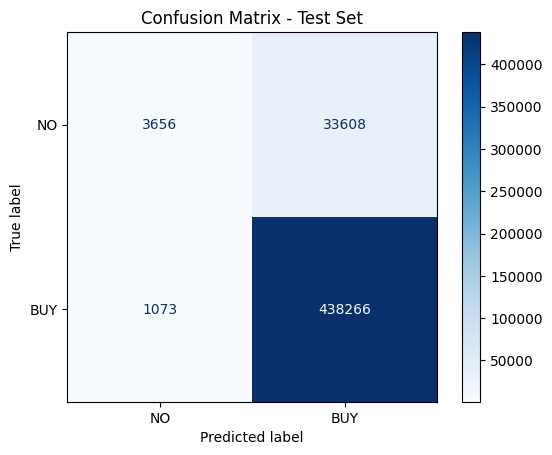

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_prob = model.predict(dvalid)

# Convert to class labels
y_pred = (y_pred_prob > 0.65).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "BUY"])

# Plot
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set ")
plt.show()


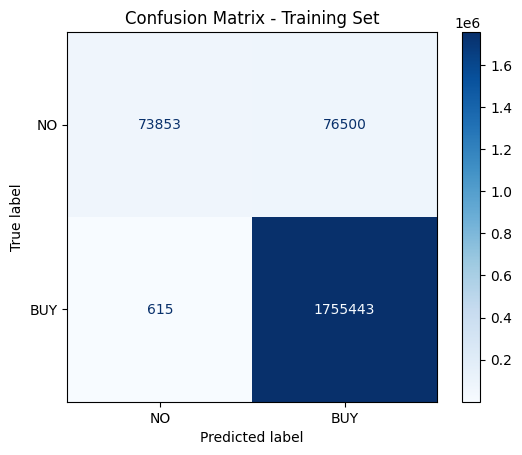

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_prob = model.predict(dtrain)

# Convert to class labels
y_pred = (y_pred_prob > 0.65).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "BUY"])

# Plot
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Training Set")
plt.show()


%training 3m data

In [1]:
import xgboost as xgb
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
# ==== Load the PyTorch data ====
data = torch.load("Train_Data/options_buy_model_data.pt")
X = data['X']           # shape: (N, 15, 15)
labels = data['labels'] # shape: (N,)

# ==== Clean Data ====
X = torch.nan_to_num(X, nan=0.0, posinf=10.0, neginf=-10.0)
labels = torch.nan_to_num(labels, nan=0.0)

# Flatten and move to CPU
X_np = X.view(X.shape[0], -1).cpu().numpy()     # (N, 225)
y_np = labels.cpu().numpy().astype(np.int32)    # (N,)

# Ensure labels are integers (BUY=1, NO=0)
if y_np.dtype != np.int64 and y_np.dtype != np.int32:
    y_np = y_np.astype(np.int32)

# ==== Train/Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)
# Calculate class weights
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
scale_pos_weight = num_neg / num_pos 
# Convert to DMatrix# Manual weights: higher for minority class (e.g., BUY)
weights = np.where(y_train == 1, scale_pos_weight, 1.0)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dvalid = xgb.DMatrix(X_test, label=y_test)


C:\Users\sibaj\AppData\Local\Temp\ipykernel_14716\64866942.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("Train_Data/options_buy_model_data.pt")


In [ ]:

# ==== Model Parameters ====
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 9,
    'learning_rate': 0.05,
    'tree_method': 'hist',
    'device': 'cuda'
}

# ==== Checkpoint Utility ====
def get_latest_checkpoint(prefix="xgb_checkpoint_", ext="ubj"):
    files = glob.glob(f"{prefix}*.{ext}")
    if not files:
        print("❌ No checkpoint files found.")
        return None
    latest = max(files, key=os.path.getctime)
    print(f"✅ Found latest checkpoint: {latest}")
    return latest

checkpoint_path = get_latest_checkpoint()

# ==== Train or Resume Training ====
if checkpoint_path:
    print(f"🔁 Resuming training from: {checkpoint_path}")
    booster = xgb.Booster()
    booster.load_model(checkpoint_path)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        evals=[(dvalid, 'validation')],
        xgb_model=booster,
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )
else:
    print("🚀 Starting new training...")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=600,
        evals=[(dvalid, 'validation')],
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )


✅ Found latest checkpoint: xgb_checkpoint_6170.ubj
🔁 Resuming training from: xgb_checkpoint_6170.ubj
[0]	validation-logloss:0.14819
[1]	validation-logloss:0.14814
[2]	validation-logloss:0.14808
[3]	validation-logloss:0.14803
[4]	validation-logloss:0.14802
[5]	validation-logloss:0.14791
[6]	validation-logloss:0.14790
[7]	validation-logloss:0.14791
[8]	validation-logloss:0.14791
[9]	validation-logloss:0.14791
[10]	validation-logloss:0.14792
[11]	validation-logloss:0.14791
[12]	validation-logloss:0.14792
[13]	validation-logloss:0.14790
[14]	validation-logloss:0.14788
[15]	validation-logloss:0.14789
[16]	validation-logloss:0.14789
[17]	validation-logloss:0.14790
[18]	validation-logloss:0.14789
[19]	validation-logloss:0.14788
[20]	validation-logloss:0.14788
[21]	validation-logloss:0.14788
[22]	validation-logloss:0.14788
[23]	validation-logloss:0.14788
[24]	validation-logloss:0.14789
[25]	validation-logloss:0.14790
[26]	validation-logloss:0.14791
[27]	validation-logloss:0.14791
[28]	validati

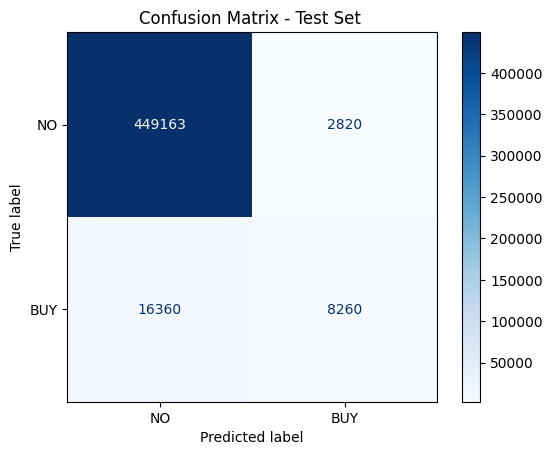

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_prob = model.predict(dvalid)

# Convert to class labels
y_pred = (y_pred_prob > 0.65).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "BUY"])

# Plot
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set ")
plt.show()


<h3>Custom scaling with DART</h3>

In [18]:
import xgboost as xgb
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ==== Load Data ====
data = np.load("Train_Data/option_train_labeled_3m.npz", allow_pickle=True)
X = data['X']
X_reduced =  X[:, :, [1, 4, 5, 6, 7, 8, 9]].reshape(data['X'].shape[0], -1)  # Flatten for XGBoost
labels = data['labels']

# Encode 'BUY' as 1, 'NO' as 0
le = LabelEncoder()
y = le.fit_transform(labels)  # Assumes 'BUY' and 'NO' are only labels


X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

# ==== Model Parameters ====
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth':20,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'device': 'cuda'
}
# params = {
#     'booster': 'dart',               # Use DART instead of default 'gbtree'
#     'objective': 'binary:logistic',
#     'max_depth': 12,
#     'learning_rate': 0.1,
#     'tree_method': 'hist',
#     'device': 'cuda',
#     'rate_drop': 0.3,                # Probability of dropping each tree
#     'skip_drop': 0.5                 # Chance to skip dropout altogether in a round
# }

# ==== Checkpoint Utility ====
def get_latest_checkpoint(prefix="xgb_checkpoint_", ext="ubj"):
    files = glob.glob(f"{prefix}*.{ext}")
    if not files:
        print("❌ No checkpoint files found.")
        return None
    latest = max(files, key=os.path.getctime)
    print(f"✅ Found latest checkpoint: {latest}")
    return latest

checkpoint_path = get_latest_checkpoint()

# ==== Train or Resume Training ====
if checkpoint_path:
    print(f"🔁 Resuming training from: {checkpoint_path}")
    booster = xgb.Booster()
    booster.load_model(checkpoint_path)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=601,
        evals=[(dvalid, 'validation')],
        xgb_model=booster,
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )
else:
    print("🚀 Starting new training...")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=601,
        evals=[(dvalid, 'validation')],
        callbacks=[
            xgb.callback.EarlyStopping(rounds=10),
            xgb.callback.TrainingCheckPoint(directory='.', name='xgb_checkpoint', interval=50)
        ]
    )


❌ No checkpoint files found.
🚀 Starting new training...
[0]	validation-logloss:0.27144
[1]	validation-logloss:0.26914
[2]	validation-logloss:0.26721
[3]	validation-logloss:0.26568
[4]	validation-logloss:0.26391
[5]	validation-logloss:0.26250
[6]	validation-logloss:0.26104
[7]	validation-logloss:0.25959
[8]	validation-logloss:0.25755
[9]	validation-logloss:0.25658
[10]	validation-logloss:0.25583
[11]	validation-logloss:0.25508
[12]	validation-logloss:0.25370
[13]	validation-logloss:0.25161
[14]	validation-logloss:0.25124
[15]	validation-logloss:0.25089
[16]	validation-logloss:0.25036
[17]	validation-logloss:0.25010
[18]	validation-logloss:0.24902
[19]	validation-logloss:0.24874
[20]	validation-logloss:0.24830
[21]	validation-logloss:0.24737
[22]	validation-logloss:0.24717
[23]	validation-logloss:0.24574
[24]	validation-logloss:0.24563
[25]	validation-logloss:0.24555
[26]	validation-logloss:0.24410
[27]	validation-logloss:0.24404
[28]	validation-logloss:0.24397
[29]	validation-logloss:0.

In [ ]:
import numpy as np
import xgboost as xgb

# ==== Load Data ====
data = np.load("Train_Data/option_train_labeled.npz", allow_pickle=True)
X = data['X']
X_reduced =  X[:, :, [1, 4, 5, 6, 7, 8, 9]].reshape(data['X'].shape[0], -1)  # Flatten for XGBoost
labels = data['labels']

# Encode 'BUY' as 1, 'NO' as 0
le = LabelEncoder()
y = le.fit_transform(labels)  # Assumes 'BUY' and 'NO' are only labels


X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [ ]:
import xgboost as xgb
booster = xgb.Booster()
booster.load_model("Saved_XGB_models/final_model.ubj")



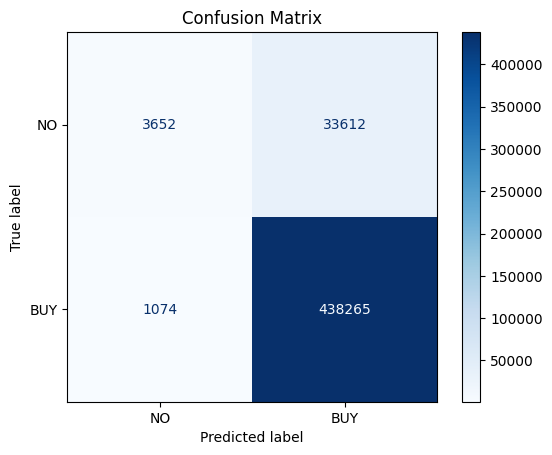

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_prob = model.predict(dvalid)

# Convert to class labels
y_pred = (y_pred_prob > 0.65).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "BUY"])

# Plot
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


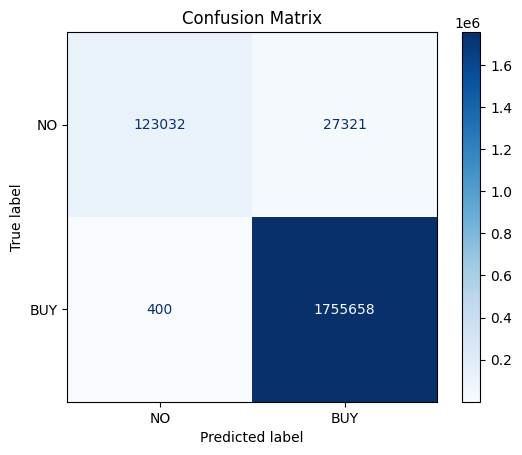

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities
y_pred_prob = model.predict(dtrain)

# Convert to class labels
y_pred = (y_pred_prob > 0.65).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "BUY"])

# Plot
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [6]:
model.save_model("final_model_3m_16_depth.ubj")

In [4]:
X_test.shape

(476603, 150)